# MetaCyc Pathway Abundance Analysis


## Setup

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
from pathlib import Path


%matplotlib inline

In [2]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [3]:
import sys
sys.path.append(root.as_posix())

import utils

In [4]:
metagenome = "pathway_abundance"
core_metrics_res = data_dir / f"{metagenome}_core_metrics"
picrust_res = data_dir / "q2-picrust2_fullpipeline"

output_dir = data_dir / f"{metagenome}_downstream_analysis"
output_dir.mkdir(exist_ok=True)

## Beta diversity

In [5]:
! ls $core_metrics_res

bray_curtis_distance_matrix.qza  jaccard_pcoa_results.qza
bray_curtis_emperor.qzv		 observed_features_vector.qza
bray_curtis_pcoa_results.qza	 rarefied_table.qza
evenness_vector.qza		 scatter-plot-recov-day.qzv
jaccard_distance_matrix.qza	 shannon_vector.qza
jaccard_emperor.qzv		 spearman-recov-day.qza


### Visulization of PCA plot


In [6]:
meta = pd.read_csv(data_dir / "metadata.tsv", sep="\t", index_col=0)
meta.head()

,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
sample-id,,,,,,
EG2580,P042,liquid,F,13,17.0,2
EG2559,P043,liquid,M,15,17.0,2
EG2537,P042,liquid,F,0,17.0,1
EG2518,P043,liquid,M,0,17.0,1
EG2490,P030,formed,F,0,NaN,1


#### Jaccard Index

In [7]:
pcs_j = q2.Artifact.load(core_metrics_res / "jaccard_pcoa_results.qza").view(OrdinationResults)

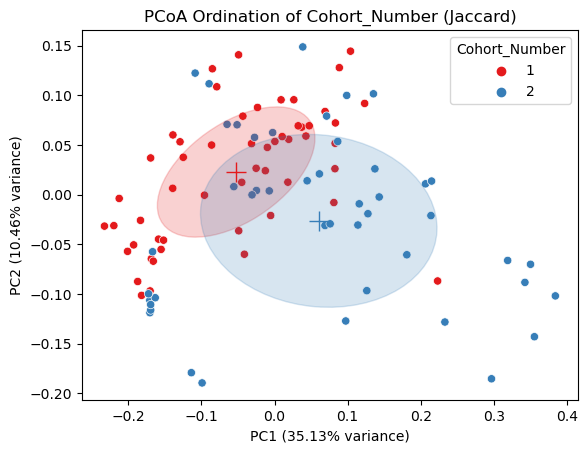

In [8]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    "Cohort_Number",
    output_file=vis_dir / "jaccard_pcoa_Cohort_Number.png",
)

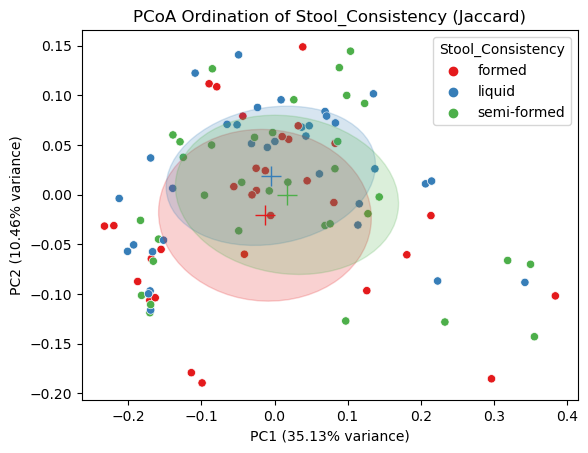

In [9]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    category="Stool_Consistency",
    output_file=vis_dir / "jaccard_pcoa_Stool_Consistency.png",
)

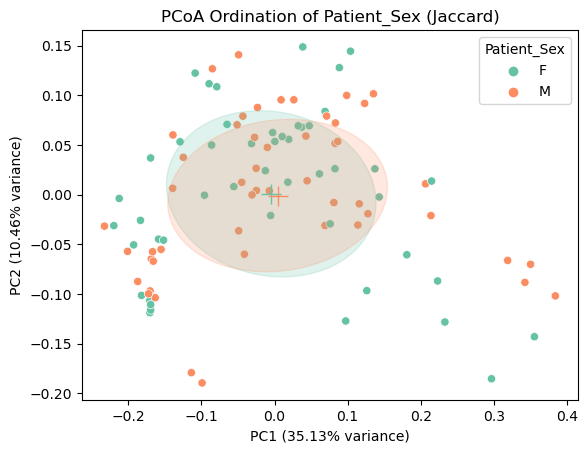

In [ ]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_j,
    meta,
    category="Patient_Sex",
    output_file=vis_dir / "jaccard_pcoa_Patient_Sex.png",
    palette="Set2"
)

#### Bray-Curtis Index

In [11]:
pcs_bc = q2.Artifact.load(core_metrics_res / "bray_curtis_pcoa_results.qza").view(OrdinationResults)

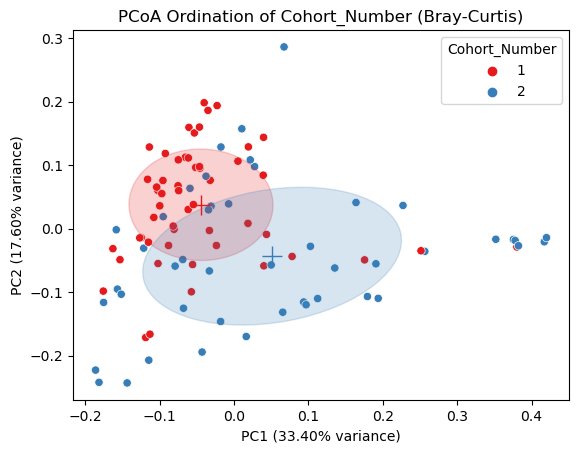

In [ ]:
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Cohort_Number",
    output_file=vis_dir / "bray_curtis_pcoa_Cohort_Number.png",
)

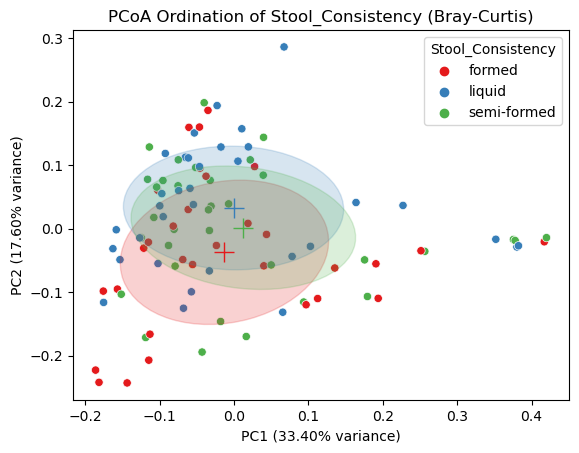

In [13]:
# plot stool consistency
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Stool_Consistency",
    output_file=vis_dir / "bray_curtis_pcoa_Stool_Consistency.png",
)

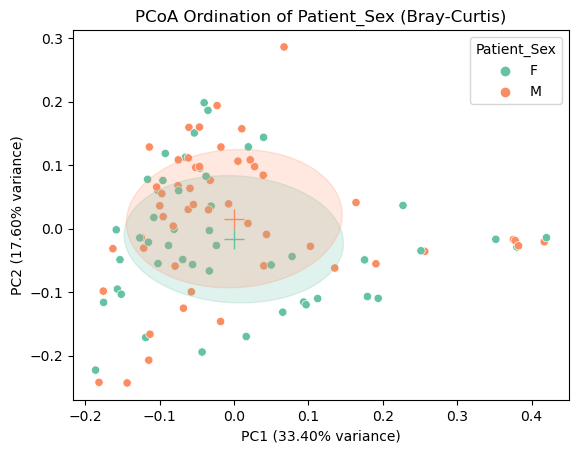

In [15]:
# plot patient sex
utils.plot_pcoa_with_confidence_ellipse(
    pcs_bc,
    meta,
    metric="Bray-Curtis",
    category="Patient_Sex",
    output_file=vis_dir / "bray_curtis_pcoa_Patient_Sex.png",
    palette="Set2"
)

### Adonis test

### Beta correlation

In [ ]:
! qiime diversity beta-correlation \
    --i-distance-matrix $core_metrics_res/bray_curtis_distance_matrix.qza \
    --m-metadata-file $core_metrics_res/metadata_fillna.tsv \
    --m-metadata-column Recovery_Day \
    --p-intersect-ids \
    --o-metadata-distance-matrix $output_dir/spearman-recov-day.qza \
    --o-mantel-scatter-visualization $output_dir/scatter-plot-recov-day.qzv

## Differential abundance

### Between cohort

In [ ]:
# Run ANCOM-BC
! qiime composition ancombc \
    --i-table $picrust_res/{metagenome}.qza \
    --m-metadata-file $data_dir/metadata_categorical-cohort.tsv \
    --p-formula cohort \
    --p-reference-levels "cohort::Before abduction" \
    --o-differentials $output_dir/ancombc_differentials.qza

# Generate a barplot of differentially abundant taxa between environments
! qiime composition da-barplot \
    --i-data $output_dir/ancombc_differentials.qza \
    --o-visualization $output_dir/ancombc_da_barplot.qzv

# Generate a table of these same values for all taxa
! qiime composition tabulate \
    --i-data $output_dir/ancombc_differentials.qza \
    --o-visualization $output_dir/ancombc_results.qzv